# Reading Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from utils.general import read_raw_data

x, y, metadata = read_raw_data(score_path='labels/fts_score.csv', data_path='labels/fts_data.csv')
# x, y, metadata = read_raw_data(score_path='labels/fco_score.csv', data_path='labels/fco_data.csv')

# x = np.concatenate((x1, x2), axis=0)
# y = np.concatenate((y1, y2), axis=0)
# metadata = np.concatenate((metadata1, metadata2), axis=0)

1384it [00:00, 5679.96it/s]


# Binary scoring

In [2]:
score_threshold = 6
labels = np.array(y)
labels[labels <= score_threshold] = 0
labels[labels > score_threshold] = 1
unique, counts = np.unique(labels, return_counts=True)
for idx, c in enumerate(counts):
    print(f'label: {idx}: {c} samples')

label: 0: 1102 samples
label: 1: 270 samples


# Config

In [3]:
## Network
HIDDEN_DIM = 64
OUTPUT_DIM = 2
BATCH_SIZE = 4
IS_BID = True
NUM_LAYERS = 2

## Optimizer  
lr = 1e-3
weight_decay=0.001

## Scheduler
step_size=3
gamma=0.5

early_stop_patience = 5

# Feature Selection

In [4]:
def feature_selection(remove_features):
    idxs = []
    for p in remove_features:
        idxs.extend(list(range(p*4, p*4 + 4)))
    return np.delete(x, idxs, axis=2)

head_landmarks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
data = feature_selection([])
print(data.shape)

NUM_FEATURES = 100 - (len([]) * 4)

torch.Size([1372, 50, 100])


# Augmentation

In [5]:
import pandas as pd
# currently simple sub sampling

def simple_subsample(data_, pos, neg):
    data_pos = data_[pos]
    data_neg = data_[neg]
    data_neg = data_neg[0:len(data_pos)]
    
    return np.concatenate((data_pos, data_neg), axis=0)

pos = np.where(labels==1)
neg = np.where(labels==0)

data = simple_subsample(data, pos, neg)
labels = simple_subsample(labels, pos, neg)
metadata = simple_subsample(metadata, pos, neg)

labels_names = pd.DataFrame({'label': labels, 'metadata': metadata})

print('x', data.shape)
print('y', labels.shape)


x (540, 50, 100)
y (540,)


# Data Set & Loaders

In [6]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data, labels_names, test_size=0.2, random_state=42, stratify=labels)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=42,
                                                  stratify=y_train['label'])

class TTDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels.iloc[idx]['label'], idx

def create_dataloaders(batch_size):
    train_data = TTDataset(x_train, y_train)
    test_data = TTDataset(x_test, y_test)
    validation_data = TTDataset(x_val, y_val)
    
    print('#train samples: ', len(train_data))
    print('#valid samples: ', len(validation_data))
    print('#test  samples: ', len(test_data))
    
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    return train_loader, validation_loader, test_loader

    
train_loader, validation_loader, test_loader = create_dataloaders(BATCH_SIZE)

#train samples:  259
#valid samples:  173
#test  samples:  108


# Learning

In [7]:
import torch.nn as nn
import math

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.scale = 1. / math.sqrt(hidden_size)

    def forward(self, hidden, outputs):
        hidden = hidden.unsqueeze(1)
        values = outputs.transpose(0, 1)
        outputs = outputs.transpose(0, 1).transpose(1, 2)

        weights = torch.bmm(hidden, outputs)
        scores = F.softmax(weights.mul_(self.scale), dim=2)
        linear_combination = torch.bmm(scores, values).squeeze(1)
        return linear_combination


class Network(nn.Module):
    def __init__(self, input_dim, h_dim, out_dim, num_layers=1, bidirectional=True):
        super().__init__()
        self.num_layers = num_layers
        self.h_dim = h_dim
        self.bidirectional = bidirectional
        self.dropout = nn.Dropout(0.5)

        # Attention layer - unused so far
        hid_bidirectional = h_dim * 2 if bidirectional else h_dim
        self.atten = Attention(hid_bidirectional)

        # LSTM
        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=h_dim,
                            num_layers=num_layers,
                            bidirectional=bidirectional, batch_first=True)  # dropout
        # FC layer
        self.fc = nn.Linear(hid_bidirectional, out_dim, bias=True)

        # To convert class scores to log-probability we'll apply log-softmax
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, X):
        lay_times_dir = self.num_layers * 2 if self.bidirectional else self.num_layers
        h0 = torch.zeros(lay_times_dir, BATCH_SIZE, HIDDEN_DIM).to(device)
        c0 = torch.zeros(lay_times_dir, BATCH_SIZE, HIDDEN_DIM).to(device)

        out, (h_t, c_t) = self.lstm(X, (h0, c0))
        if self.bidirectional:
            cell_state = torch.cat([c_t[-1], c_t[-2]], dim=1)
        else:
            cell_state = c_t[-1]

        y = self.fc(cell_state)
        yt_log_proba = self.log_softmax(y)
        return yt_log_proba

In [8]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print(device)

cuda


epoch 0 | train loss : 0.7033354043960571 validation loss: 0.6852612495422363 
epoch 0 | train acc : 0.62890625 validation acc: 0.5988372093023255 
epoch 1 | train loss : 0.6790855526924133 validation loss: 0.6534194946289062 
epoch 1 | train acc : 0.58984375 validation acc: 0.6162790697674418 
epoch 2 | train loss : 0.6864568591117859 validation loss: 0.6832383275032043 
epoch 2 | train acc : 0.61328125 validation acc: 0.6046511627906976 
epoch 3 | train loss : 0.6795699000358582 validation loss: 0.6895024180412292 
epoch 3 | train acc : 0.5390625 validation acc: 0.5523255813953488 
epoch 4 | train loss : 0.6572232246398926 validation loss: 0.653357207775116 
epoch 4 | train acc : 0.6484375 validation acc: 0.563953488372093 
epoch 5 | train loss : 0.6467276215553284 validation loss: 0.6366080641746521 
epoch 5 | train acc : 0.67578125 validation acc: 0.6453488372093024 
epoch 6 | train loss : 0.6127570867538452 validation loss: 0.6224353909492493 
epoch 6 | train acc : 0.6953125 valid

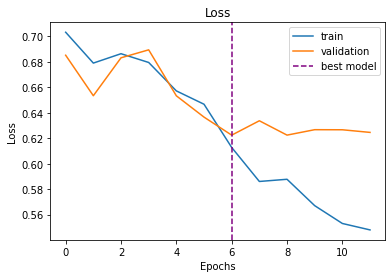

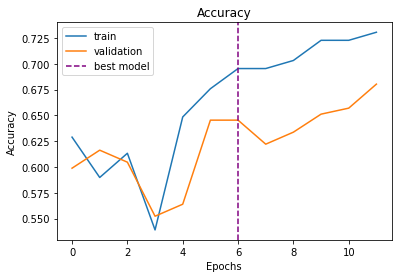

In [9]:
from utils.learn import train_model

model = Network(NUM_FEATURES, HIDDEN_DIM, OUTPUT_DIM,
                bidirectional=IS_BID, num_layers=NUM_LAYERS).to(device)
model_name = f'b{BATCH_SIZE}_lr{lr}_sz{step_size}_g{gamma}_h{HIDDEN_DIM}_nl{NUM_LAYERS}_no_head.pt' #no_head
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.NLLLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

train_model(model, model_name, BATCH_SIZE, device, early_stop_patience,
            train_loader, validation_loader, test_loader,
            optimizer, scheduler, loss_fn)

# False analysis 

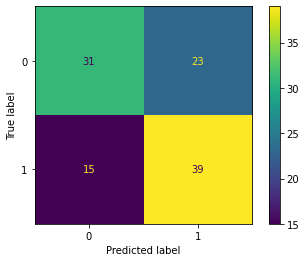

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from utils.learn import predict
from visualization import points_visualization
from IPython.display import Image

model.load_state_dict(torch.load('model_results/' + model_name))
model.eval()
correct_idx, wrong_idx, y_pred, y_true = predict(model, test_loader, device, BATCH_SIZE)

cm = confusion_matrix(y_true, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [17]:
print('correct', correct_idx)
print('wrong', wrong_idx)
print()

debug_idx = 3
debug_name = y_test.iloc[debug_idx]['metadata']['name']
debug_amount = y_test.iloc[debug_idx]['metadata']['frames']

debug_X = x_test[debug_idx]

print('debug original idx in test set: ', debug_idx)
print('true label:', y_test.iloc[debug_idx]['label'])
print('correct:', debug_idx in correct_idx)
print('shot name: ', debug_name)
print('frames', debug_amount)

correct [3, 4, 5, 6, 7, 8, 9, 12, 13, 16, 18, 19, 20, 22, 24, 25, 26, 29, 30, 31, 32, 34, 35, 42, 43, 45, 47, 48, 49, 50, 51, 53, 55, 56, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 78, 80, 81, 82, 83, 84, 85, 88, 92, 93, 94, 95, 96, 97, 99, 100, 103, 104, 105]
wrong [0, 1, 2, 10, 11, 14, 15, 17, 21, 23, 27, 28, 33, 36, 37, 38, 39, 40, 41, 44, 46, 52, 54, 57, 63, 72, 77, 79, 86, 87, 89, 90, 91, 98, 101, 102, 106, 107]

debug original idx in test set:  3
true label: 1.0
correct: True
shot name:  fts_20_7.2_9
frames 13


finished saving gif: fts_20_7.2_9


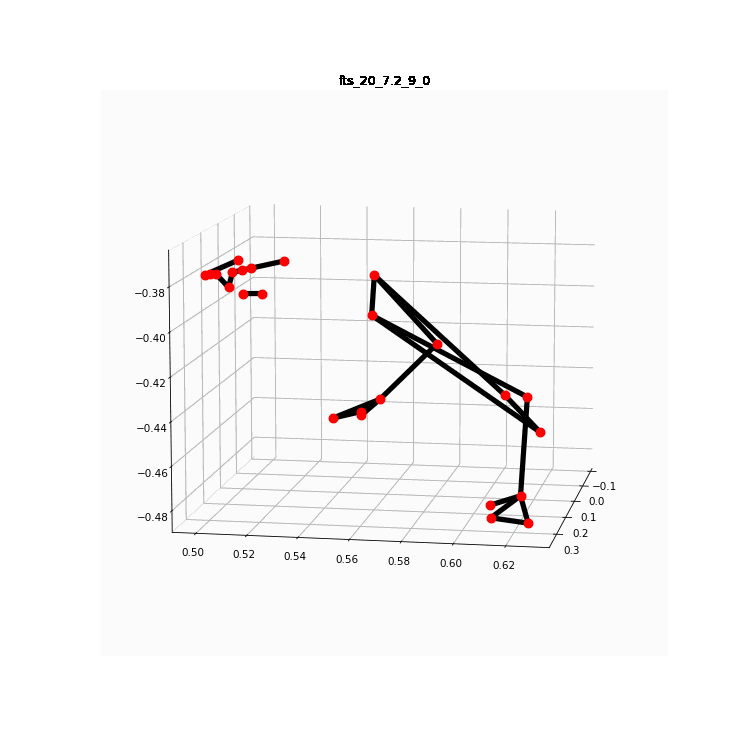

In [18]:
points_visualization.create_gif_for_given_shot(debug_name, debug_X, debug_amount,[])
with open(f'visualization/shots_3d_demo/{debug_name}.gif','rb') as f:
    display(Image(data=f.read(), format='png'))